# Modelling Liquid Level in a Tank

In this notebook, we will model the transient behaviour of  a simple system shown below.
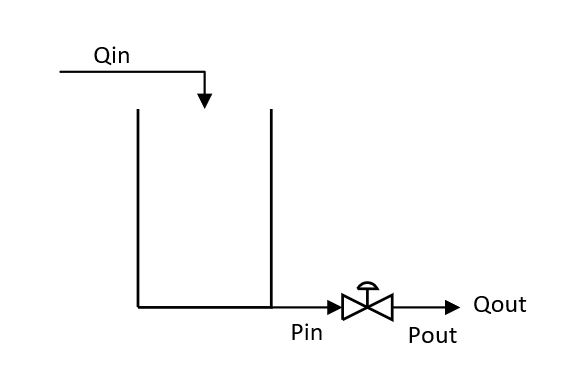

Here, we have a tank that receives a flow $Q_{in}$ and the outlet flow  $Q_{out}$  is through a valve at the bottom of the tank.

We will look at the main equations governing the valve and the tank, and how they can be solved using `numpy` arrays. 

First, let's import the libraries we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Flow Through a Valve
The valve equation is typically given by:

$Q=V_{op}K\sqrt{ (\Delta P)}$

where:
- $Q$=volumetric flow rate ($m^3/s$)
- $V_{op}$ = valve opening (fraction)
- $K$= valve conductance i.e. the reciprocal of resistance ($m^3/(s \times Pa^{0.5})$)
- $\Delta P$ = pressure drop across the valve ($Pa$)

Let's define a function for the valve equation.

In [2]:
def valve_flow(dp, op, k):
  q = op * k * np. sqrt(dp)
  return q

Consider a valve located at the bottom of an atmospheric water tank. The tank air pressure is at $P_{atm}$ but at the bottom of the tank, the pressure will be $P_{atm}+\rho g h$.

It means that the inlet pressure of the valve will also be $P_{atm}+\rho g h$. And if the outlet of the valve, the pressure is $P_{atm}$, then the valve equation will reduced to:

$Q=V_{op}K\sqrt{ (P_{atm}+\rho g h - P_{atm} )}=V_{op}K\sqrt{ (\rho g h)}$ 

Consider the following:


In [3]:
rho = 1000 #kg/m3
g = 9.81 
h = 10 #m

op = 0.5 # fraction
k = 0.1

Then, we have:

In [4]:
Patm = 101000 #atmospheric pressure in Pa
Pin = rho*g*h + Patm
Pout = Patm
dp = Pin-Pout

qout = valve_flow(dp, op, k)
qout

15.660459763365825

Let's try to calculate flow rate $Q$ as a function of valve opening:

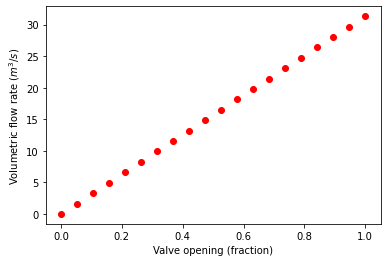

In [5]:
openings = np.linspace(0,1,20)

for op in openings:
    q = valve_flow(dp, op, k)
    
    # plt.figure()
    plt.scatter(op, q, c='r')
    plt.xlabel('Valve opening (fraction)')
    plt.ylabel('Volumetric flow rate ($m^3/s$)')

How about if we had a fixed opening but different pressure drops?

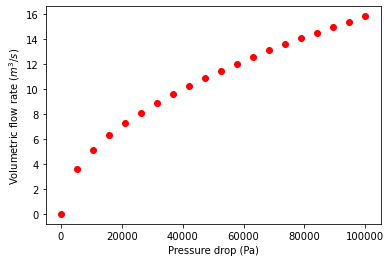

In [6]:
op = 0.5
pressure_drops = np.linspace(0,100000,20)

for dp in pressure_drops:
    q = valve_flow(dp, op, k)
    
    plt.scatter(dp, q, c='r')
    plt.xlabel('Pressure drop (Pa)')
    plt.ylabel('Volumetric flow rate ($m^3/s$)')

## Liquid Level in a Tank

Now consider the water level, $h$, in a tank. The change in the level as a function of time, $dh/dt$ will be:

$\frac{dh}{dt} A= Q_{in} - Q_{out}$

where:
- $Q_{in}$ = flow into the tank
- $A$ = the cross-sectional area of the tank.
- $Q_{out}$= flow out of the tank which is given by $V_{op}K\sqrt{ \rho g h}$.

Notice that the term $\sqrt{\rho g h}$ will introduce non-linearity in the equation. Many of the examples related to tank modelling would simplify this to:

$Q_{out}=V_{op}K\sqrt{ \rho g } \times h$ 

We then have:

$\frac{dh}{dt} A= Q_{in} - V_{op}K\sqrt{ \rho g } \times h$

Let's try to solve this equation to model the change in level in the tank.

We first define the cross-sectional area of the tank in ($m^3$):

In [7]:
A = 5 # m^2

Now, we define the opening ($V_{op}$) and the valve conductance ($K$):

In [8]:
# valve parameters
op = 0.5 # fraction
k = 0.005 #

We will need to define how frequent (time step, $dt$) and how long we want to solve the equation:

In [9]:
dt = 1 # time step in seconds
times = np.arange(0,250,dt) 

We now initialise the arrays for $Q_{in}$, $Q_{out}$ and $h$ with arrays filled with zeros.

For $Q_{in}$ however, we introduce a flow (step change) of 2 $m^3/s$.

In [10]:
# initialise arrays of data that we need
qin = np.zeros(len(times))
qin[50:] = 2 # after a certain period, qin will be 2 m3/s

qout = np.zeros(len(times))
h = np.zeros(len(times))
level = np.zeros(len(times))

We now will solve the following equation:

$\frac{dh}{dt} A= Q_{in} - V_{op}K\sqrt{ \rho g } \times h$

which can be arranged such that:

$dh= \frac{ Q_{in} - V_{op}K\sqrt{ \rho g } \times h }{A} {dt}$

At each time step, we will perform the following:
1. Calculate the flow rate across the valve to get $Q_{out}$, 
2. Update the current level $h$ by adding the change in level $dh$ based on the equation above.

In [11]:
for i in range(1,len(times)):

  qout[i] = op * k * np.sqrt(rho*g) * h[i-1]
  h[i] = h[i-1] + (qin[i-1] - qout[i-1])/A * dt

In the calculations above, notice that we have done the following:
1. In both of the equations, we calculate the current values of `qout` and `h` (i.e. `qout[i]` and `h[i]` respectively) using the values from the previous time (`[i-1]`). This is called explicit solutions.
2. We start the `for` loop from the second elements by using `range(1, len(times))` instead of `range(0, len(times))`. Hence, the very first elements of `qin`, `qout` and `h` are used as the initial conditions (here all initials values equal to zero).   


Now let's plot the level.

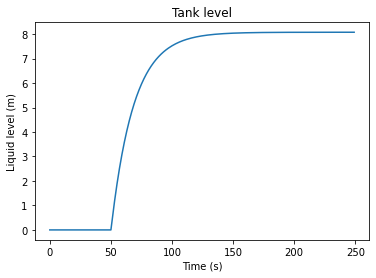

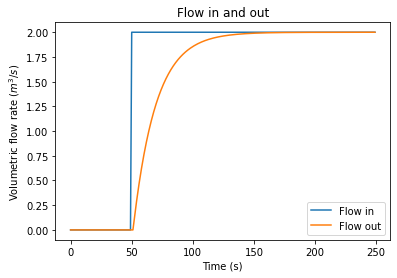

In [12]:
plt.figure()
plt.plot(times, h)
plt.title('Tank level')
plt.xlabel('Time (s)')
plt.ylabel('Liquid level (m)')

plt.figure()
plt.plot(times, qin, label='Flow in')
plt.plot(times, qout, label='Flow out')
plt.title('Flow in and out')
plt.xlabel('Time (s)')
plt.ylabel('Volumetric flow rate ($m^3/s$)')
plt.legend()

Let's now create an animation of the liquid level.

In [13]:
import imageio

images = []

for i in range(0,len(times),10):
    plt.figure()
    plt.plot(times[0:i], h[0:i], 'b')
    plt.xlim(0, 250)
    plt.ylim(0, 10)
    plt.xlabel('Time (s)')
    plt.ylabel('Liquid level (m)')
    plt.title('Time = '+ str(times[i]) +' sec')
    plt.savefig('plot_'+str(i)+'.png')
    plt.close()
    
    images.append(imageio.imread('plot_'+str(i)+'.png'))
    
imageio.mimsave('liquid_level.gif', images)

from IPython.display import Image
Image('liquid_level.gif')

import glob, os
# delete the figures
for f in glob.glob("plot_*.png"):
    os.remove(f)  

## Transfer Function

The equation:

$\frac{dh}{dt} A= Q_{in} - V_{op}K\sqrt{ \rho g } \times h$

can be transformed into a transfer function by using Laplace transform:

$Ah(s) s = Q_{in}(s) - V_{op}K\sqrt{ \rho g } \times h(s) $

$(As + V_{op}K\sqrt{ \rho g }) \times h(s)= Q_{in}(s) $

$\frac{h(s)}{Q_{in}(s)}=  \frac{1}{As + V_{op}K \sqrt{ \rho g }}$

This can be define using a transfer function provided by `scipy`.

In [14]:
from scipy import signal

num = [1]
den = [A, op*k*np.sqrt(rho*g)]

tf = signal.TransferFunction(num, den)

We now have to introduce the input (in this case $Q_{in}$) by using `signal.lsim()`.

In [15]:
tout, tf_y, tf_x = signal.lsim(tf, qin, times)

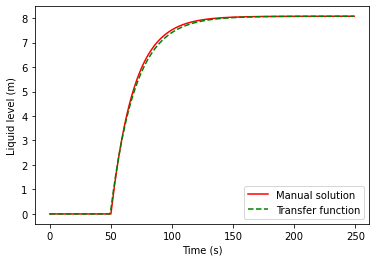

In [16]:
plt.plot(times, h, 'r', label='Manual solution')
plt.plot(tout, tf_y,'--g', label='Transfer function')

plt.xlabel('Time (s)')
plt.ylabel('Liquid level (m)')
plt.legend()

## PID Controller 

We will now explore the case where we have a controller to control the opening of the valve such that its opening can be controlled to meet the level set point.

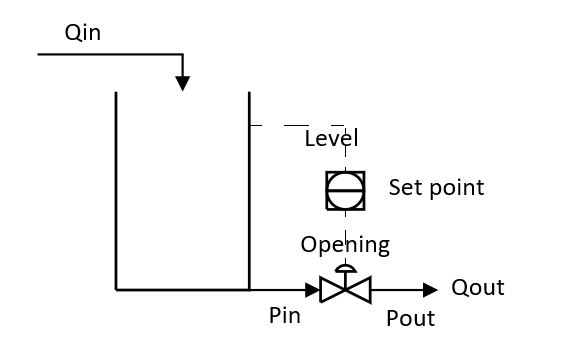

Similar as before, we first define the arrays required for the tank model.

In [17]:
# tank parameter
A = 5
k = 0.01

# timestep
dt = 1
times = np.arange(0,800,dt)

qin = np.zeros(len(times))
qin[50:] = 5 # m3/s
qout = np.zeros(len(times)) 
h = np.zeros(len(times))

Now, initialise the arrays to hold the PID parameters

$op(t) = K_pe(t)+ K_i \int e(t) dt + K_d e(t)$ 

where $e(t)$ is the error or deviation of the level from its setpoint:

$e(t) = sp(t) - h(t)$

In [18]:
op = np.ones(len(times)) * 0.5 # valve operating opening
error = np.zeros(len(times)) # error = deviation between actual level and setpoint
error_I = np.zeros(len(times)) # accumulation of error i.e. the integral part in PID

# controller settings
sp = np.ones(len(times)) * 20 # setpoint

Kp = 0.01 # proportional gain
Ki = 0.002 # integral gain

We perform similar calculations for transient tank modelling as before, except now the valve opening is calculated by the controller. 

To highlight the effects of adding the controller, we will include the controller only after $t=300$ sec. For $t=0$ to $t=300$ sec, the valve is manually opened at 0.5.

In [19]:
for i in range(1,len(times)):
  qout[i] = op[i-1] * k * np.sqrt(rho*g) * h[i-1]
  h[i] = h[i-1] + (qin[i-1] - qout[i-1])/A * dt
    
  # only perform after 300 sec
  if times[i] > 300:
    # calculate level and error from previous time step    
    error[i] = h[i-1] - sp[i-1] 
    error_I[i] = error_I[i-1] + error[i-1]*dt 
      
    op[i] = Kp * error[i] + Ki * error_I[i] # we only use PI control here                               
    op[i] = np.clip(op[i],0,1)  # make sure op is between 0-1 

Plot the results.

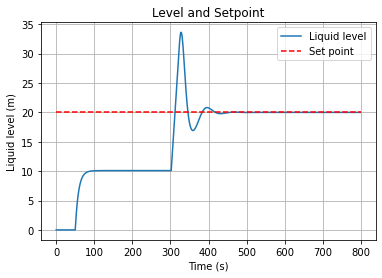

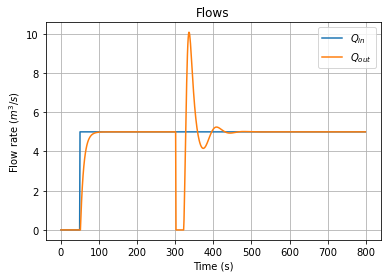

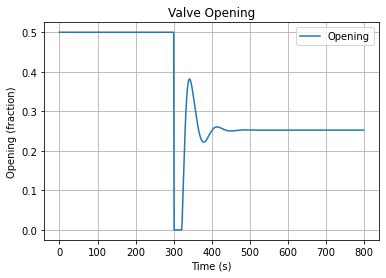

In [20]:
plt.figure()
plt.plot(times, h, label='Liquid level')
plt.plot(times, sp,'--r', label='Set point')
plt.title('Level and Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Liquid level (m)')
plt.legend()
plt.grid()

plt.figure()
plt.plot(times, qin, label='$Q_{in}$')
plt.plot(times, qout, label='$Q_{out}$')
plt.title('Flows')
plt.xlabel('Time (s)')
plt.ylabel('Flow rate ($m^3/s$)')
plt.legend()
plt.grid()

plt.figure()
plt.plot(times, op, label='Opening')
plt.title('Valve Opening')
plt.xlabel('Time (s)')
plt.ylabel('Opening (fraction)')
plt.legend()
plt.grid()